# Применение линейных моделей для анализа дифференциальной экспрессии генов

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

Предоставлены данные об экспресси генов в различных образцах тканей 18 больных колоректальным раком. Для каждого были собраны образцы здоровой ткани прямой кишки, опухоли и метастаз в различные органы. Задача &mdash; понять, как же отличается экспрессия в этих образцах и дисрегуляция каких генов лежит в основе заболевания. Данные взяты из  этой [статьи](https://pubmed.ncbi.nlm.nih.gov/25049118/). 


#### 0. Загрузка данных

In [3]:
raw_data = pd.read_csv("http://genomedata.org/gen-viz-workshop/intro_to_deseq2/tutorial/E-GEOD-50760-raw-counts.tsv", sep = "\t")
raw_data.head()

,Gene ID,Gene Name,SRR975551,SRR975552,SRR975553,SRR975554,SRR975555,SRR975556,SRR975557,SRR975558,...,SRR975595,SRR975596,SRR975597,SRR975598,SRR975599,SRR975600,SRR975601,SRR975602,SRR975603,SRR975604
0,ENSG00000000003,TSPAN6,6617,1352,1492,3390,1464,1251,207,1333,...,2786,1717,1691,6192,722,680,2608,2436,1739,2134
1,ENSG00000000005,TNMD,69,1,20,23,12,4,20,2,...,18,7,10,40,14,1,16,0,2,7
2,ENSG00000000419,DPM1,2798,714,510,1140,1667,322,273,621,...,852,1095,1066,1273,405,597,974,1000,1287,1250
3,ENSG00000000457,SCYL3,486,629,398,239,383,290,164,452,...,244,156,256,422,95,255,331,165,347,349
4,ENSG00000000460,C1orf112,466,342,73,227,193,35,38,184,...,121,105,172,293,73,148,180,160,288,100


Каждый столбец в этой таблице соответствует одному из образцов, а каждый ряд &mdash; определенному транскрипту.  
Загрузим таблицу с аннотацией.

In [4]:
sampleData = pd.read_csv("http://genomedata.org/gen-viz-workshop/intro_to_deseq2/tutorial/E-GEOD-50760-experiment-design.tsv",  sep = "\t")
sampleData.head()

,Run,Sample Characteristic[biopsy site],Sample Characteristic Ontology Term[biopsy site],Sample Characteristic[disease],Sample Characteristic Ontology Term[disease],Sample Characteristic[disease staging],Sample Characteristic Ontology Term[disease staging],Sample Characteristic[individual],Sample Characteristic Ontology Term[individual],Sample Characteristic[organism],Sample Characteristic Ontology Term[organism],Sample Characteristic[organism part],Sample Characteristic Ontology Term[organism part],Factor Value[biopsy site],Factor Value Ontology Term[biopsy site],Analysed
0,SRR975551,primary tumor,http://www.ebi.ac.uk/efo/EFO_0000616,colorectal cancer,http://www.ebi.ac.uk/efo/EFO_0005842,Stage IV Colorectal Cancer,NaN,AMC_2,NaN,Homo sapiens,http://purl.obolibrary.org/obo/NCBITaxon_9606,colon,http://purl.obolibrary.org/obo/UBERON_0001155,primary tumor,http://www.ebi.ac.uk/efo/EFO_0000616,Yes
1,SRR975552,primary tumor,http://www.ebi.ac.uk/efo/EFO_0000616,colorectal cancer,http://www.ebi.ac.uk/efo/EFO_0005842,Stage IV Colorectal Cancer,NaN,AMC_3,NaN,Homo sapiens,http://purl.obolibrary.org/obo/NCBITaxon_9606,colon,http://purl.obolibrary.org/obo/UBERON_0001155,primary tumor,http://www.ebi.ac.uk/efo/EFO_0000616,Yes
2,SRR975553,primary tumor,http://www.ebi.ac.uk/efo/EFO_0000616,colorectal cancer,http://www.ebi.ac.uk/efo/EFO_0005842,Stage IV Colorectal Cancer,NaN,AMC_5,NaN,Homo sapiens,http://purl.obolibrary.org/obo/NCBITaxon_9606,colon,http://purl.obolibrary.org/obo/UBERON_0001155,primary tumor,http://www.ebi.ac.uk/efo/EFO_0000616,Yes
3,SRR975554,primary tumor,http://www.ebi.ac.uk/efo/EFO_0000616,colorectal cancer,http://www.ebi.ac.uk/efo/EFO_0005842,Stage IV Colorectal Cancer,NaN,AMC_6,NaN,Homo sapiens,http://purl.obolibrary.org/obo/NCBITaxon_9606,colon,http://purl.obolibrary.org/obo/UBERON_0001155,primary tumor,http://www.ebi.ac.uk/efo/EFO_0000616,Yes
4,SRR975555,primary tumor,http://www.ebi.ac.uk/efo/EFO_0000616,colorectal cancer,http://www.ebi.ac.uk/efo/EFO_0005842,Stage IV Colorectal Cancer,NaN,AMC_7,NaN,Homo sapiens,http://purl.obolibrary.org/obo/NCBITaxon_9606,colon,http://purl.obolibrary.org/obo/UBERON_0001155,primary tumor,http://www.ebi.ac.uk/efo/EFO_0000616,Yes


#### 1. Предобработка данных



Образцы бывают следующих типов: 

In [5]:
sampleData["Sample Characteristic[biopsy site]"].unique()

array(['primary tumor', 'normal',
       'colorectal cancer metastatic in the liver'], dtype=object)

Для генов  TREM1 and CTGF построим боксплоты для выборок образцов каждого типа. 

[Text(0.5, 1.0, 'Распределение экспрессии гена CTGF для 3 типов тканей')]

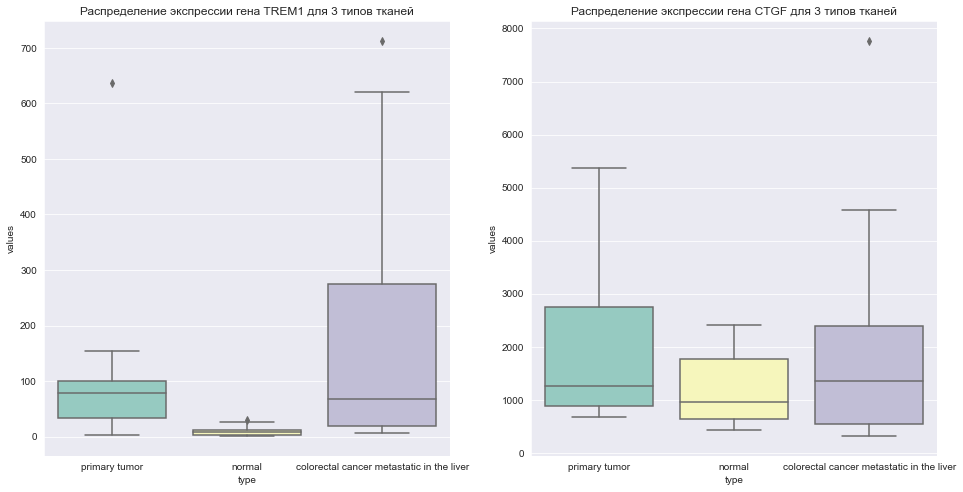

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('darkgrid')
aux_tab = raw_data.iloc[np.where(raw_data['Gene Name'] == 'TREM1')]
aux_tab = pd.DataFrame({"type": np.array(sampleData["Sample Characteristic[biopsy site]"]), 
                        "values": np.array(aux_tab[aux_tab.columns[2:]])[0]})
fig = plt.figure(figsize=(16,8))
ax_1 = fig.add_subplot(121)
ax_1 = sns.boxplot(x='type', y='values', data=aux_tab, palette="Set3")
ax_1.set(title='Распределение экспрессии гена TREM1 для 3 типов тканей')

aux_tab = raw_data.iloc[np.where(raw_data['Gene Name'] == 'CTGF')]
aux_tab = pd.DataFrame({"type": np.array(sampleData["Sample Characteristic[biopsy site]"]), 
                        "values": np.array(aux_tab[aux_tab.columns[2:]])[0]})

ax_2 = fig.add_subplot(122) 
ax_2 = sns.boxplot(x='type', y='values', data=aux_tab, palette="Set3")
ax_2.set(title='Распределение экспрессии гена CTGF для 3 типов тканей')


Перейдем от названий генов к длинным именам транскриптов, чтобы избежать возможных дальнейших дубликатов.

In [7]:
gene_names = dict(zip(raw_data['Gene ID'], raw_data['Gene Name']))
gene_names

{'ENSG00000000003': 'TSPAN6',
 'ENSG00000000005': 'TNMD',
 'ENSG00000000419': 'DPM1',
 'ENSG00000000457': 'SCYL3',
 'ENSG00000000460': 'C1orf112',
 'ENSG00000000938': 'FGR',
 'ENSG00000000971': 'CFH',
 'ENSG00000001036': 'FUCA2',
 'ENSG00000001084': 'GCLC',
 'ENSG00000001167': 'NFYA',
 'ENSG00000001460': 'STPG1',
 'ENSG00000001461': 'NIPAL3',
 'ENSG00000001497': 'LAS1L',
 'ENSG00000001561': 'ENPP4',
 'ENSG00000001617': 'SEMA3F',
 'ENSG00000001626': 'CFTR',
 'ENSG00000001629': 'ANKIB1',
 'ENSG00000001630': 'CYP51A1',
 'ENSG00000001631': 'KRIT1',
 'ENSG00000002016': 'RAD52',
 'ENSG00000002079': 'MYH16',
 'ENSG00000002330': 'BAD',
 'ENSG00000002549': 'LAP3',
 'ENSG00000002586': 'CD99',
 'ENSG00000002587': 'HS3ST1',
 'ENSG00000002726': 'AOC1',
 'ENSG00000002745': 'WNT16',
 'ENSG00000002746': 'HECW1',
 'ENSG00000002822': 'MAD1L1',
 'ENSG00000002834': 'LASP1',
 'ENSG00000002919': 'SNX11',
 'ENSG00000002933': 'TMEM176A',
 'ENSG00000003056': 'M6PR',
 'ENSG00000003096': 'KLHL13',
 'ENSG00000003

Для последующего анализа  будем использовать только образцы типов control и primary tumour. Рассмотрим матрицу значений экспрессии для образцов с этими типами. 

In [8]:
rawCounts = raw_data[raw_data.columns[np.hstack((0, np.where(sampleData["Sample Characteristic[biopsy site]"] == 'primary tumor')[0] + 2,
          np.where(sampleData["Sample Characteristic[biopsy site]"] == 'normal')[0] + 2))]]


In [9]:
rawCounts.head()

,Gene ID,SRR975551,SRR975552,SRR975553,SRR975554,SRR975555,SRR975556,SRR975557,SRR975558,SRR975559,...,SRR975578,SRR975579,SRR975580,SRR975581,SRR975582,SRR975583,SRR975584,SRR975585,SRR975586,SRR975587
0,ENSG00000000003,6617,1352,1492,3390,1464,1251,207,1333,2126,...,1008,310,2704,674,1121,1776,981,1185,2012,3190
1,ENSG00000000005,69,1,20,23,12,4,20,2,3,...,10,13,21,5,19,3,10,7,2,6
2,ENSG00000000419,2798,714,510,1140,1667,322,273,621,1031,...,271,213,783,268,467,452,419,473,607,1274
3,ENSG00000000457,486,629,398,239,383,290,164,452,172,...,243,159,324,257,360,409,310,430,248,314
4,ENSG00000000460,466,342,73,227,193,35,38,184,174,...,21,17,131,52,57,86,70,65,79,251


Так как изучать изменения в экспрессии генов, которые практически не экспрессируются, не имеет смысла, удалим транскрипты, суммарная экспрессия которых меньше 5.

In [10]:
rawCounts.shape

(65217, 38)

In [11]:
rawCounts['sum'] = np.sum(rawCounts, axis=1)

<ipython-input-11-eecb714dbaf9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rawCounts['sum'] = np.sum(rawCounts, axis=1)


In [12]:
rawCounts = rawCounts.drop(np.where(rawCounts['sum'] < 5)[0])
del rawCounts['sum']
rawCounts

,Gene ID,SRR975551,SRR975552,SRR975553,SRR975554,SRR975555,SRR975556,SRR975557,SRR975558,SRR975559,...,SRR975578,SRR975579,SRR975580,SRR975581,SRR975582,SRR975583,SRR975584,SRR975585,SRR975586,SRR975587
0,ENSG00000000003,6617,1352,1492,3390,1464,1251,207,1333,2126,...,1008,310,2704,674,1121,1776,981,1185,2012,3190
1,ENSG00000000005,69,1,20,23,12,4,20,2,3,...,10,13,21,5,19,3,10,7,2,6
2,ENSG00000000419,2798,714,510,1140,1667,322,273,621,1031,...,271,213,783,268,467,452,419,473,607,1274
3,ENSG00000000457,486,629,398,239,383,290,164,452,172,...,243,159,324,257,360,409,310,430,248,314
4,ENSG00000000460,466,342,73,227,193,35,38,184,174,...,21,17,131,52,57,86,70,65,79,251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65198,ENSG00000281904,1,1,2,1,0,3,2,3,2,...,0,2,3,1,1,2,1,2,2,1
65203,ENSG00000281909,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
65206,ENSG00000281912,15,8,6,5,9,17,4,10,7,...,7,9,12,10,11,20,9,11,13,9
65212,ENSG00000281918,0,0,0,0,0,0,1,0,0,...,0,0,2,0,0,1,0,0,2,0


Примерно половина генов была удалена из рассмотрения. Значит достаточно много генов были слабо экспрессированы

Оценим дисперсию генов

In [13]:
disp = []
for i in range (rawCounts.shape[0]):
    disp.append((np.mean(np.array(rawCounts.iloc[i])[1:] ** 2) - np.mean(np.array(rawCounts.iloc[i])[1:]) ** 2) * rawCounts.shape[1] / (rawCounts.shape[1] - 1))

Text(0.5, 1.0, 'Распределение значений дисперсии уровней экспрессии генов')

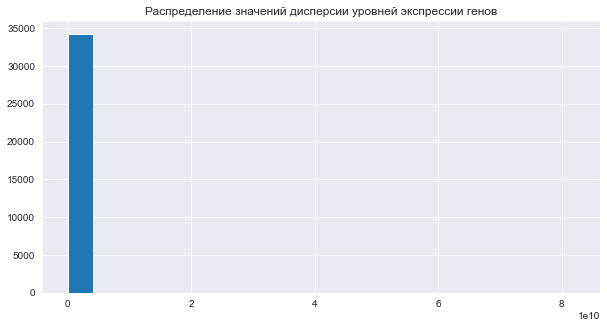

In [14]:
plt.figure(figsize=(10,5))
plt.hist(disp, bins=20)
plt.title('Распределение значений дисперсии уровней экспрессии генов')

Отсортируем по значению дисперсии и возьмем 5000 генов с наибольшим разбросом дисперсии.

In [15]:
disp = sorted(disp)
disp[-5000:]

[112887.72972972973,
 112954.48648648648,
 113045.8918918919,
 113060.27027027027,
 113113.67567567568,
 113116.75675675676,
 113186.5945945946,
 113193.78378378379,
 113219.45945945945,
 113367.35135135135,
 113468.0,
 113471.08108108108,
 113513.18918918919,
 113523.45945945945,
 113649.78378378379,
 113670.32432432432,
 113775.08108108108,
 113810.0,
 113816.16216216216,
 113929.13513513513,
 113969.18918918919,
 113978.43243243243,
 114063.67567567568,
 114183.83783783784,
 114199.24324324324,
 114487.83783783784,
 114712.75675675676,
 114715.83783783784,
 114743.56756756757,
 114802.1081081081,
 114836.0,
 114847.2972972973,
 114948.97297297297,
 114989.02702702703,
 115014.7027027027,
 115072.21621621621,
 115076.32432432432,
 115080.43243243243,
 115169.78378378379,
 115217.02702702703,
 115224.21621621621,
 115276.5945945946,
 115403.94594594595,
 115578.54054054055,
 115616.54054054055,
 115706.91891891892,
 115755.18918918919,
 115792.16216216216,
 115843.51351351352,
 115857

Как можно заметить из гистограммы почти все гены имеют дисперсию уровней экспрессии близкую к нулю, а в рамках нашего исследования интерес представляют гены с большой дисперсией экспрессии - то есть те, у которых уровни экспрессии для здоровых и больных тканей сильно различаются, что говорит о том, что гены, которые мы рассматриваем имеют прямое отношение к зараженности наших тканей. 

#### 2. Построение линейной модели

Построим для гена TREM1 самую простую линейную регрессию, используя дизайн $y = x \theta$, где $y$ &mdash; значение экспрессии гена, а $x$ &mdash; параметр, обозначающий, является ли образец контролем или раковым.

In [16]:
X = np.hstack((np.ones(np.where(sampleData["Sample Characteristic[biopsy site]"] == 'primary tumor')[0].shape[0]),
               -np.ones(np.where(sampleData["Sample Characteristic[biopsy site]"] == 'normal')[0].shape[0]))).reshape(-1, 1)
y = np.array(raw_data.iloc[np.where(raw_data['Gene Name'] == 'TREM1')][raw_data.columns[2:]])[0][:X.shape[0]]

In [17]:
linear_model = LinearRegression().fit(X,y)

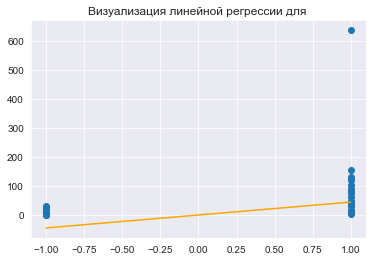

In [18]:
linear_model.coef_
plt.scatter(X, y)
plt.title('Визуализация линейной регрессии для ')
plt.plot(X, X * linear_model.coef_, color='orange')

Как мы видим, в некотором приближении, линейная регрессия неплохо описывает наши данные. Посчитаем коэффициент линейной регрессии для каждого гена.

In [19]:
def get_gene_coef(sample):
    X = np.hstack((np.ones(np.where(sampleData["Sample Characteristic[biopsy site]"] == 'primary tumor')[0].shape[0]),
                   -np.ones(np.where(sampleData["Sample Characteristic[biopsy site]"] == 'normal')[0].shape[0]))).reshape(-1, 1)
    y = np.array(raw_data.iloc[np.where(raw_data['Gene ID'] == sample)][raw_data.columns[2:]])[0][:X.shape[0]]
    linear_model = LinearRegression().fit(X,y)
    return linear_model.coef_[0]

In [20]:
CountSubset = rawCounts['Gene ID']
coefs = CountSubset.apply(get_gene_coef)

#### 3. Сделаем выводы

In [21]:
top_coefs = np.hstack((np.array(CountSubset).reshape(np.array(CountSubset).shape[0], 1),
                      np.array(coefs).reshape(np.array(coefs).shape[0], 1)))
top_coefs = sorted(top_coefs, key=lambda x: x[1])
top_coefs[-5:], top_coefs[:5]

([array(['ENSG00000102837', 10964.707602339176], dtype=object),
  array(['ENSG00000164692', 12726.979532163743], dtype=object),
  array(['ENSG00000168542', 17109.68274853801], dtype=object),
  array(['ENSG00000108821', 18779.71783625731], dtype=object),
  array(['ENSG00000156508', 22966.980994152043], dtype=object)],
 [array(['ENSG00000198804', -66644.76754385965], dtype=object),
  array(['ENSG00000210082', -37474.51169590643], dtype=object),
  array(['ENSG00000211890', -35647.337719298244], dtype=object),
  array(['ENSG00000162896', -27910.621345029234], dtype=object),
  array(['ENSG00000132465', -26444.195906432742], dtype=object)])

In [22]:
print('Наибольшей разницей между здоровым и злокачественным образцом обладают гены:', gene_names['ENSG00000198804'], gene_names['ENSG00000210082'], 
      gene_names['ENSG00000211890'], gene_names['ENSG00000162896'], gene_names['ENSG00000132465'])

Наибольшей разницей между здоровым и злокачественным образцом обладают гены: MT-CO1 MT-RNR2 IGHA2 PIGR JCHAIN


Отрицательные коэффициенты означают, что в нормальных тканях данный ген был экспрессирован сильнее, чем в зараженных. В нашем случае все нижепредставленные гены недоэкспрессированы в зараженных тканях, по сравнению с контрольными.

Ген MT-CO1 - компонент цитохром-с-оксидазы, последнего фермента в митохондриальной цепи переноса электронов, который управляет окислительным фосфорилированием.

Ген MT-RNR2 играет роль защитного фактора, защищает от смерти, вызванной множеством различных генов семейной болезни Альцгеймера и белками бета-амилоида при болезни Альцгеймера. 

Ген IGHA2 есть постоянная область иммуноглобулинов, также известных как антитела.

Ген PIGR является частью семейства иммуноглобулинов, связывает полимерные молекулы иммуноглобулина на базолатеральной поверхности эпителиальных клеток.

Ген JCHAIN связан со связыванием и захватом лигандов скавенджер-рецепторами и взаимодействием на клеточной поверхности на стенке сосудов.

Для топ 100 генов из пункта 3 повторим анализ, но теперь сравнивая экспрессию между образцами из контрольной группы и метастаз. Сравним полученные коэффиценты.

In [253]:
top_coefs = np.hstack((np.array(top_coefs)[:,0].reshape(np.array(top_coefs).shape[0], 1), 
                       abs(np.array(top_coefs)[:,1]).reshape(np.array(top_coefs).shape[0], 1)))
top_coefs = sorted(top_coefs, key=lambda x: x[1], reverse=True)
top_coefs = top_coefs[:100]

In [271]:
def get_gene_coef_new(sample):
    X = np.hstack((-np.ones(np.where(sampleData["Sample Characteristic[biopsy site]"] == 'normal')[0].shape[0]),
                   np.ones(np.where(sampleData["Sample Characteristic[biopsy site]"] == 'colorectal cancer metastatic in the liver')[0].shape[0]))).reshape(-1, 1)
    y = np.array(raw_data.iloc[np.where(raw_data['Gene ID'] == sample)][raw_data.columns[2:]])[0][18:]
    linear_model = LinearRegression().fit(X,y)
    return linear_model.coef_[0]

In [272]:
CountSubset_new = pd.Series(np.array(top_coefs)[:,0])
coefs_new = CountSubset_new.apply(get_gene_coef_new)
coefs_new

0    -56285.390093
1    -21146.936533
2    -45455.715170
3    -47521.492260
4    -34087.620743
          ...     
95     2333.416409
96     3071.196594
97     -258.034056
98    -3481.911765
99     2010.455108
Length: 100, dtype: float64

In [273]:
coefs_new = sorted(coefs_new)
coefs_new[:5]

[-56285.39009287925,
 -47521.492260061925,
 -45455.71517027865,
 -34087.62074303406,
 -25013.167182662542]

Таким образом, можно заметить, что коэффициенты получились достаточно похожими, что и в предыдущем пункте, причем если обратить внимание, то в среднем уровень экспрессии среди 100 этих генов растет от первого к последнему. Это говорит о том, что гены, которые были недоэкспрессированы в опухолевых тканях, также недоэкспрессированы и в метостазе и их уровни экспрессии достаточно похожи.